In [1]:
import tweepy
import pandas as pd
import numpy as np
import requests
import json
from timeit import default_timer as timer
import re

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

### Table of Contents

1. [Gathering/Scraping Data](#gathering)
2. [Assessing Data](#assess)
3. [Identified Issues](#issues)
4. [Cleaning](#cleaning)
5. [Analysis](#analysis)

## Gathering / Scraping Data <a name="gathering"></a>

In [2]:
#grab archive from local files
tweets_archive = pd.read_csv('data/twitter-archive-enhanced-2.csv')

In [3]:
#grab TSV for predictions from url
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
dog_predictions = pd.read_csv(url,sep='\t')

In [4]:
#grab tweets based on tweet id from tweepy
#lifted lovingly from https://www.promptcloud.com/blog/scrape-twitter-data-using-python-r
with open('twitter_credentials.json') as cred_data:
    info = json.load(cred_data)
    consumer_key = info['CONSUMER_KEY']
    consumer_secret = info['CONSUMER_SECRET']
    access_key = info['ACCESS_KEY']
    access_secret = info['ACCESS_SECRET']

In [5]:
auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_key, access_secret)

api = tweepy.API(auth,wait_on_rate_limit=True)

In [6]:
tweet_ids = tweets_archive.tweet_id.values

In [7]:
#call tweepy/twitter API for additional data based on tweet ids
#this takes 20-30min - avoid running
#comment out below to run again
#if == 0

fail_dict = {}
extended_data = []
start = timer()
with open('tweet_json.txt','w') as outfile:
    for tweet_id in tweet_ids:
        try: 
            tweet = api.get_status(tweet_id,tweet_mode='extended')
            print("Got")
            json.dump(tweet._json,outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fail_dict[tweet_id] = e
            pass
end = timer()
print(end-start)
    

SyntaxError: invalid syntax (<ipython-input-7-bead3ff01bdd>, line 4)

In [8]:
len(fail_dict), len(tweet_ids)

NameError: name 'fail_dict' is not defined

In [9]:
#saving fail_dict for later, because scraping takes forever
fail_dicts = pd.DataFrame(data=fail_dict.values(),index = fail_dict.keys(), columns = ['message'])
fail_dicts.to_csv('fail_dict.csv',sep='\t' , encoding = 'utf-8')

NameError: name 'fail_dict' is not defined

In [10]:
#grab tweets in to a list
tweets_list = []
for line in open('tweet_json.txt','r'):
    tweets_list.append(json.loads(line))

## Asessing Data <a name="assess"></a>

In [11]:
#figure out what the json looks like
tweets_list[5]

{'created_at': 'Sat Jul 29 00:08:17 +0000 2017',
 'id': 891087950875897856,
 'id_str': '891087950875897856',
 'full_text': "Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh",
 'truncated': False,
 'display_text_range': [0, 138],
 'entities': {'hashtags': [{'text': 'BarkWeek', 'indices': [129, 138]}],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 891087942176911360,
    'id_str': '891087942176911360',
    'indices': [139, 162],
    'media_url': 'http://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg',
    'url': 'https://t.co/kQ04fDDRmh',
    'display_url': 'pic.twitter.com/kQ04fDDRmh',
    'expanded_url': 'https://twitter.com/dog_rates/status/891087950875897856/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'small': {'w': 680, 'h':

In [12]:
#collect necessary data from twitter harvest
columns = ['tweet_id','favorite_count','retweet_count']
transfer = []
retweet_ID=[]
retweet_counter=0
for tweet in tweets_list: 
    ID = np.int64(tweet['id'])
    favorite_count = tweet['favorite_count']
    retweet_count = tweet['retweet_count']

    transfer.append((ID,favorite_count,retweet_count))

tweets_extended = pd.DataFrame(transfer, columns = columns)

In [13]:
tweets_extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweet_id          2340 non-null int64
favorite_count    2340 non-null int64
retweet_count     2340 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


In [14]:
tweets_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [15]:
dog_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [16]:
tweets_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [17]:
#look at denominator values 
tweets_archive['rating_denominator'].unique(), tweets_archive['rating_numerator'].unique()

(array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
        130, 110,  16, 120,   2], dtype=int64),
 array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
         182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
           3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
         143,  121,   20,   26,    2,  144,   88], dtype=int64))

In [18]:
#check denominators and numerators 
mask = tweets_archive['rating_denominator'] != 10
weird_denom = tweets_archive[mask]

weird_denom_ids = weird_denom['tweet_id']

for i in range(len(weird_denom)):
   print(weird_denom.index[i], weird_denom['text'].tolist()[i])
    


313 @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
342 @docmisterio account started on 11/15/15
433 The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
516 Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
784 RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
902 Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1068 After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
1120 Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
1165 Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
1202 

Some values are replies and retweets, which we will strip. 
Based on context it looks like we have a few different categories where the denominators are weird:
* multiple dogs
    * 433
    * 902
    * 1120
    * 1228
    * 1254
    * 1274
    * 1351
    * 1433
    * 1635
    * 1779
    * 1843
* grabbed the wrong value
    * 1068 should be 14/10, not 9/11
    * 1165 should be 13/10, not 4/20
    * 1202 should be 11/10 not 50/50
    * 1662 should be 10/10 not 7/11
    * 2335 should be 9/10 not 3 1/2
* no actual dog rating
    * 516 - should be dropped
    

In [19]:
#collect incorrect dog denominator ratings in to different groups
wrong_dog_rating = [1068,1165,1202,1662,2335]
no_dog_rating = [516]
multiple_dog_rating = weird_denom.index.drop(wrong_dog_rating+no_dog_rating)

In [20]:
#take a second look at numerators
tweets_archive['rating_numerator'].unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88], dtype=int64)

In [21]:
#check ridiculously high values 
print(tweets_archive[tweets_archive['rating_numerator'] == 1776].text.iloc[0])

This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh


Doesn't appear to be anything programmatically wrong with this example, though it's obviously going to skew things. We'll assume that the denominators are our best indicator of something having gone wrong from a string extraction perspective for now.

In [22]:
#what do we have for sources?
tweets_archive['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [23]:
#check if any bad values are in any of the dog categories
tweets_archive.puppo.unique()

array(['None', 'puppo'], dtype=object)

In [24]:
tweets_archive.floofer.unique()

array(['None', 'floofer'], dtype=object)

In [25]:
tweets_archive.pupper.unique()

array(['None', 'pupper'], dtype=object)

In [26]:
tweets_archive.puppo.unique()

array(['None', 'puppo'], dtype=object)

In [27]:
#determine if anything strange is in the names
dog_names = tweets_archive.name.unique()
np.sort(dog_names)[::-1]

array(['very', 'unacceptable', 'this', 'the', 'such', 'space', 'quite',
       'one', 'old', 'officially', 'not', 'my', 'mad', 'light', 'life',
       'just', 'infuriating', 'incredibly', 'his', 'getting', 'by', 'an',
       'all', 'actually', 'a', 'Zuzu', 'Zooey', 'Zoey', 'Zoe', 'Ziva',
       'Zeus', 'Zeke', 'Zeek', 'Zara', 'Yukon', 'Yogi', 'Yoda', 'Wyatt',
       'Wishes', 'Winston', 'Winnie', 'Winifred', 'Wilson', 'Willy',
       'Willow', 'Willie', 'William', 'Willem', 'Wiggles', 'Wesley',
       'Watson', 'Walter', 'Wally', 'Wallace', 'Walker', 'Waffles',
       'Wafer', 'Vixen', 'Vinscent', 'Vinnie', 'Vincent', 'Vince',
       'Venti', 'Ulysses', 'Tyrus', 'Tyrone', 'Tyr', 'Tycho', 'Tupawc',
       'Tug', 'Tuco', 'Tucker', 'Tuck', 'Trooper', 'Tripp', 'Trip',
       'Trigger', 'Trevith', 'Traviss', 'Travis', 'Tove', 'Torque',
       'Tonks', 'Tommy', 'Tom', 'Toffee', 'Todo', 'Toby', 'Tobi', 'Tito',
       'Titan', 'Tino', 'Timofy', 'Timmy', 'Timison', 'Timber', 'Tilly',
       'Ti

In [28]:
#figure out if we're missing names for dogs - looking for items that are lower-cased or otherwise obviously not a name
missing_names = tweets_archive[tweets_archive.name.str.contains('^[a-z]|None')]
missing_names.sample(8)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
291,838085839343206401,8.380855e+17,2.894131e+09,2017-03-04 17:56:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@bragg6of8 @Andy_Pace_ we are still looking fo...,NaN,NaN,NaN,NaN,15,10,None,None,None,None,None
154,862096992088072192,NaN,NaN,2017-05-10 00:08:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please don't send perfectly...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/862096992...,13,10,None,None,None,None,None
1091,737445876994609152,NaN,NaN,2016-05-31 00:49:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Just wanted to share this super rare Rainbow F...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/737445876...,13,10,None,None,floofer,None,None
1501,692142790915014657,6.920419e+17,4.196984e+09,2016-01-27 00:31:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These are some pictures of Teddy that further ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692142790...,13,10,None,None,None,None,None
1877,675109292475830276,NaN,NaN,2015-12-11 00:26:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",C'mon guys. We've been over this. We only rate...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675109292...,9,10,a,None,None,None,None
2333,666337882303524864,NaN,NaN,2015-11-16 19:31:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an extremely rare horned Parthenon. No...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666337882...,9,10,an,None,None,None,None
1429,697596423848730625,NaN,NaN,2016-02-11 01:42:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a pupper with a piece of pizza. Two of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697596423...,11,10,None,None,None,pupper,None
1452,695767669421768709,6.753494e+17,4.196984e+09,2016-02-06 00:35:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",If you are aware of who is making these please...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695767669...,13,10,None,None,None,None,None


In [29]:
#determine how many non-dog name 
len(missing_names)

854

## Identified Issues <a name="issues"></a>
#### Quality Issues
<ol>
    <li> Replys and retweets don't support any data analysis that we want to do. They should be dropped.</li>
    <li> Ratings with multiple dogs appear to be multiplied by number of dogs in photo. Assuming all doggos in a photo are the same rating will be used to normalize the ratings against a denominator of 10.</li>
    <li> Wrong dog ratings captured for index values in <code>wrong_dog_rating</code>. Should be replaced by correct ratings </li>
    <li><code>no_dog_rating</code> is a tweet with no dog rating and should be dropped</li>
    <li> Timestamps are in a string - convert to datetime type</li>
    <li> Names include 'None' and other non-name (not capitalized/proper noun) values. These should be replaced with a blank name. (This assumes that existing program would have caught the names if they were available, which appears valid under a spot-check)</li> 
    <li> Dog type should be a category, not string.</li> 
    <li> There are multiple listed dog stages for some dogs.</li> 
    <li> There are many missing dog-types, based on tweet data. </li>
    <li> Some numerators, containing decimals, were incorrectly included. </li>
    <li> There are some meme-ratings that are a lot higher than the other values (420 and 1776) </li>
</ol>
    


#### Tidiness
<ol>
    <li> Doggo, Floofer, Puppo and Pupper columns are extraneous. Merge in to one column with type of dog.</li>
    <li> Drop extraneous columns. </li>
    <li> Merge favorite and retweet counts from `tweets_extended` in to `tweets_archive` </li>
</ol>    
    

In [30]:
#make copies of data archives
tweets_archive_clean = tweets_archive.copy()
tweets_extended_clean = tweets_extended.copy()
dog_predictions_clean = dog_predictions.copy()

## Cleaning <a name="cleaning"></a>

Mixed tidiness and quality cleaning based on issues above. 

### Quality Issue 1 - Drop Reply and Retweets

#### Detail

Find all non-null or non-none items under reply or retweet user id's in `tweets_archive` and drop them.  

#### Code

In [31]:
#match for any values which have both reply and retweet statuses as null
mask1 = tweets_archive_clean['in_reply_to_status_id'].isnull()
mask2 = tweets_archive_clean['retweeted_status_id'].isnull()
tweets_archive_clean = tweets_archive_clean[mask1&mask2]

#### Test

In [32]:
#check that we've dropped lines
tweets_archive_clean.shape[0], tweets_archive.shape[0]

(2097, 2356)

In [33]:
#check that all remaining values are null
tweets_archive_clean['in_reply_to_status_id'].unique()

array([nan])

In [34]:
tweets_archive_clean['retweeted_status_id'].unique()

array([nan])

In [35]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

### Quality Issue 2 - Multiple Dogs have multiplied ratings

#### Detail


Normalize denomiators and numerators not corresponding to `X / 10` to `X / 10`. Find out ratio for conversion based on moving denominator to a value of `10`, then multipy that by the numerator. Round numerators to the nearest whole number. Convert any intermittent floats to ints. 

#### Code

In [36]:
multiple_dog_rating

Int64Index([ 313,  342,  433,  784,  902, 1120, 1228, 1254, 1274, 1351, 1433,
            1598, 1634, 1635, 1663, 1779, 1843],
           dtype='int64')

In [37]:
#use index from multiple-dogs identified earlier as mask for the dataframe
to_clean = tweets_archive_clean[tweets_archive_clean.index.isin(multiple_dog_rating)][['rating_numerator','rating_denominator']]
#adjust numerator by ratio required to change denominator to 10. Round to nearest int.
to_clean['rating_numerator'] = np.int64(round((to_clean['rating_numerator'] * (10 / to_clean['rating_denominator']))))
to_clean['rating_denominator'] = 10

In [38]:
#assign to dataframe 
tweets_archive_clean.loc[tweets_archive_clean.index.isin(multiple_dog_rating),('rating_numerator','rating_denominator')] = to_clean[['rating_numerator','rating_denominator']]

#### Test

In [39]:
#check if everything is normalized 
tweets_archive_clean[tweets_archive_clean.index.isin(multiple_dog_rating)][['rating_denominator','rating_numerator']]

,rating_denominator,rating_numerator
433,10,12
902,10,11
1120,10,12
1228,10,11
1254,10,10
1274,10,9
1351,10,12
1433,10,11
1635,10,11
1779,10,12


### Quality Issue 3 - Wrong ratings due to wrong part of text being parsed 

#### Detail

Grab correct ratings through a regular expression - grab all ratings and select the appropriate one. 

#### Code

In [40]:
#looks like rating values start from the end of the text string. Pull all of the ratings 
mask = tweets_archive_clean.index.isin(wrong_dog_rating)

extracted =tweets_archive_clean[mask].text.str.extractall('([0-9][0-9]*\/[0-9][0-9])')[0]
extracted


      match
1068  0         9/11
      1        14/10
1165  0         4/20
      1        13/10
1202  0        50/50
      1        11/10
1662  0         7/11
      1        10/10
2335  0         9/10
Name: 0, dtype: object

In [41]:
right_ratings = []

count = 1
#iterate through right_ratings and grab the complete ratings
for _ in range(len(extracted)):
    right_rating = extracted[count]
    right_ratings.append(right_rating)
    count += 2
    
    if count >= len(extracted):
        break
        
#manually add the last missing item
right_ratings.append(extracted[8])

In [42]:
#split completed ratings by the slash and grab the numerator 
right_numerator = []

for i in right_ratings:
    right_numerator.append(i.split('/')[0])

In [43]:
#assign numerators to tweets_archive. Assign 10 to denominators.
tweets_archive_clean.loc[tweets_archive_clean.index.isin(wrong_dog_rating),('rating_numerator','rating_denominator')] = [right_numerator,10]

#### Test

In [44]:
tweets_archive_clean[tweets_archive_clean.index.isin(wrong_dog_rating)][['rating_numerator','rating_denominator']]

,rating_numerator,rating_denominator
1068,14,10
1165,13,10
1202,11,10
1662,10,10
2335,9,10


In [45]:
tweets_archive_clean['rating_numerator'].unique()

array([13, 12, 14, 5, 11, 6, 10, 0, 24, 75, 27, 3, 7, 8, 9, 4, 1776, '14',
       '13', '11', '10', 26, 2, 1, 420, '9'], dtype=object)

In [46]:
tweets_archive_clean['rating_denominator'].unique()

array([10,  7], dtype=int64)

### Quality Issue 4 - Drop tweets with no actual dog ratings

#### Detail

Use the index harvested earlier for the tweet with no actual dog rating and drop it.

#### Code

In [47]:
tweets_archive_clean.drop(no_dog_rating,axis='index',inplace=True)

#### Test

In [48]:
#should be 0 if it's been deleted appropriately
tweets_archive_clean.isin(wrong_dog_rating).tweet_id.sum()

0

In [49]:
tweets_archive_clean['rating_numerator'].unique()

array([13, 12, 14, 5, 11, 6, 10, 0, 75, 27, 3, 7, 8, 9, 4, 1776, '14',
       '13', '11', '10', 26, 2, 1, 420, '9'], dtype=object)

### Quality Issue 6 - Dog names include "None" and other non-name values

#### Detail

Use `missing_names` generated earlier to replace non-dog names with null values. 

#### Code 

In [50]:
tweets_archive_clean['name'] = tweets_archive_clean['name'].replace(missing_names['name'].tolist(),np.NaN)

#### Test

In [51]:
tweets_archive_clean['name'].isin(missing_names['name'].tolist()).sum()

0

### Tidiness Issue 1 - Merge Extended Data in to One Dataframe

#### Detail

Merge favorite and retweet counts  from `tweets_extended` on to `tweet_archive`.

#### Code

In [52]:
len(tweets_archive_clean['tweet_id']), len(tweets_extended_clean['tweet_id']),len(dog_predictions['tweet_id'])

(2096, 2340, 2075)

In [53]:
tweets_archive_clean = tweets_archive_clean.merge(tweets_extended_clean,on='tweet_id', how ='left')

In [54]:
tweets_archive_clean[['favorite_count','retweet_count']]= tweets_archive_clean[['favorite_count','retweet_count']].dropna()

#### Test

In [55]:
tweets_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,38033.0,8320.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,32657.0,6144.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,24582.0,4068.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,41383.0,8453.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,39574.0,9162.0


In [56]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2095
Data columns (total 19 columns):
tweet_id                      2096 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2096 non-null object
source                        2096 non-null object
text                          2096 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2093 non-null object
rating_numerator              2096 non-null object
rating_denominator            2096 non-null int64
name                          1389 non-null object
doggo                         2096 non-null object
floofer                       2096 non-null object
pupper                        2096 non-null object
puppo                         2096 non-null object
favorite_count                2094 non-

### Tidiness Issue 2 - Merge various dog-type columns in to one column

#### Detail

Combine values from dog-type columns, then drop all 'None' values. 

#### Code

In [57]:
#mash all of the columns together in to one, then remove all 'None' values
tweets_archive_clean['dog_type'] = tweets_archive_clean[['doggo','floofer','pupper','puppo']].apply(
    lambda x: ''.join(x),
    axis=1)
tweets_archive_clean['dog_type'].replace('None','',regex=True,inplace=True)

#### Test

In [58]:
tweets_archive_clean.sample(10).dog_type

1924               
1445         pupper
377                
1858               
1317               
535     doggopupper
1140               
150                
1160               
571           doggo
Name: dog_type, dtype: object

In [59]:
tweets_archive_clean['dog_type'].unique()

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggopuppo',
       'doggofloofer', 'doggopupper'], dtype=object)

There are some dogs with multiple category types. Let's break off from cleaning and determine what to do with them. 

### Assess - Multi-category dogs

In [60]:
multi_dog_text = tweets_archive_clean[tweets_archive_clean['dog_type'].isin(['doggopuppo','doggofloofer','doggopupper'])]

In [61]:
multi_dog_text.text

154    Here's a puppo participating in the #ScienceMa...
161    At first I thought this was a shy doggo, but i...
358    This is Dido. She's playing the lead role in "...
415    Here we have Burke (pupper) and Dexter (doggo)...
445    This is Bones. He's being haunted by another d...
535    This is Pinot. He's a sophisticated doggo. You...
561    Pupper butt 1, Doggo 0. Both 12/10 https://t.c...
688    Meet Maggie &amp; Lila. Maggie is the doggo, L...
747    Please stop sending it pictures that don't eve...
847    This is just downright precious af. 12/10 for ...
896    Like father (doggo), like son (pupper). Both 1...
Name: text, dtype: object

In [62]:
#look through text and pictures as necessary to categorize differences. 
for text in multi_dog_text['text'].iteritems():
    print(text)

(154, "Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel")
(161, "At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk")
(358, 'This is Dido. She\'s playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7')
(415, 'Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho')
(445, "This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj")
(535, "This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd")
(

In [63]:
puppo_only = [154,358,445]
doggo_only = [161,535,747]
multi_dog = [415,561,688,847,896] #typically one doggo and one pupper

### Quality Issue 7  - Fix dog-type for tweets with multiple categories

#### Detail

Use indexes from assessed texts to assign proper value to `dog_type` for those values. Assign the value 'pair' for mutli_dog items.

#### Code

In [64]:
tweets_archive_clean.loc[puppo_only,'dog_type'] = 'puppo'

In [65]:
tweets_archive_clean.loc[doggo_only,'dog_type'] = 'doggo'

In [66]:
tweets_archive_clean.loc[multi_dog,'dog_type']= 'pair'

#### Test

In [67]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2095
Data columns (total 20 columns):
tweet_id                      2096 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2096 non-null object
source                        2096 non-null object
text                          2096 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2093 non-null object
rating_numerator              2096 non-null object
rating_denominator            2096 non-null int64
name                          1389 non-null object
doggo                         2096 non-null object
floofer                       2096 non-null object
pupper                        2096 non-null object
puppo                         2096 non-null object
favorite_count                2094 non-

In [68]:
tweets_archive_clean.dog_type.unique()

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'pair'], dtype=object)

In [69]:
tweets_archive_clean.dog_type.isin(['doggopuppo','doggofloofer','doggopupper']).sum()

0

In [70]:
tweets_archive_clean[tweets_archive_clean.dog_type.isin(['doggopuppo','doggofloofer','doggopupper'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count,dog_type


### Tidiness Issue 3 - Drop extraneous columns and handle N/A values .

#### Detail

Drop extraneous columns.

Drop columns with no retweet or favorite counts. 

NaN values to be replaced by blanks.

#### Code

In [71]:
#drop null columns
tweets_archive_clean.dropna(axis = 'columns',how='all',inplace=True)

In [72]:
#drop extraneous columns
tweets_archive_clean.drop(axis = 'columns',labels = ['doggo','floofer','pupper','puppo'],inplace=True)

In [73]:
#drop data with  retweet count values that are na
tweets_archive_clean = tweets_archive_clean[tweets_archive_clean['retweet_count'].notna()]

In [74]:
#appeared to be some values with no urls. No urls suggest no picture, which suggest no dog to rate
tweets_archive_clean = tweets_archive_clean[tweets_archive_clean['expanded_urls'].notna()]

#### Test

In [75]:
#should show non-null objects other than the name
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 2095
Data columns (total 11 columns):
tweet_id              2091 non-null int64
timestamp             2091 non-null object
source                2091 non-null object
text                  2091 non-null object
expanded_urls         2091 non-null object
rating_numerator      2091 non-null object
rating_denominator    2091 non-null int64
name                  1387 non-null object
favorite_count        2091 non-null float64
retweet_count         2091 non-null float64
dog_type              2091 non-null object
dtypes: float64(2), int64(2), object(7)
memory usage: 196.0+ KB


### Quality Issue 5 - Timestamps Should Be Date-Time Types

#### Detail

Timestamp values in `tweets_archive` are all strings. Convert to date-time format. Want ISO style: YYYY-MM-DD HH:MM:SS

#### Code

In [76]:
tweets_archive_clean['timestamp'] =pd.to_datetime(tweets_archive_clean['timestamp'])

#### Test 

In [77]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 2095
Data columns (total 11 columns):
tweet_id              2091 non-null int64
timestamp             2091 non-null datetime64[ns]
source                2091 non-null object
text                  2091 non-null object
expanded_urls         2091 non-null object
rating_numerator      2091 non-null object
rating_denominator    2091 non-null int64
name                  1387 non-null object
favorite_count        2091 non-null float64
retweet_count         2091 non-null float64
dog_type              2091 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 196.0+ KB


### Quality Issue 8 -  Fix datatypes

#### Detail

Convert dog-types to a category type in  `tweets_archive`.

`ratings_numerator` should be int64. 

`favorites_count` and `retweet_count` should be int64

#### Code

In [78]:
tweets_archive_clean['dog_type'] =tweets_archive_clean['dog_type'].astype('category')
tweets_archive_clean[['rating_numerator','favorite_count','retweet_count']] = tweets_archive_clean[[
    'rating_numerator','favorite_count','retweet_count']].astype(np.int64)

#### Test

In [79]:
#there is some remaining null objects including names and expanded urls. The expanded url data might actually mess with 
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 2095
Data columns (total 11 columns):
tweet_id              2091 non-null int64
timestamp             2091 non-null datetime64[ns]
source                2091 non-null object
text                  2091 non-null object
expanded_urls         2091 non-null object
rating_numerator      2091 non-null int64
rating_denominator    2091 non-null int64
name                  1387 non-null object
favorite_count        2091 non-null int64
retweet_count         2091 non-null int64
dog_type              2091 non-null category
dtypes: category(1), datetime64[ns](1), int64(5), object(4)
memory usage: 181.9+ KB


In [80]:
tweets_archive_clean[tweets_archive_clean['expanded_urls'].isna()].text

Series([], Name: text, dtype: object)

In [81]:
tweets_archive_clean = tweets_archive_clean.merge(dog_predictions_clean,how='left',on='tweet_id')

In [82]:
#export cleaned archive to a master xls
tweets_archive_master = tweets_archive_clean
tweets_archive_master.to_csv('tweets_archive_master.csv',encoding = 'utf-8',index=False)


### Analysis <a name="analysis"></a>


In [89]:
#saving to generic filename to ease typing
df = tweets_archive_master.copy()

In [90]:
#look at value spread for data with float int types 
df.describe()

,tweet_id,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,p1_conf,p2_conf,p3_conf
count,2.091000e+03,2091.000000,2091.0,2091.000000,2091.000000,1968.000000,1968.000000,1.968000e+03,1.968000e+03
mean,7.364943e+17,11.696318,10.0,8815.030129,2725.423242,1.202236,0.594210,1.346318e-01,6.021497e-02
std,6.712154e+16,39.712087,0.0,12763.982635,4754.551047,0.559391,0.272112,1.010130e-01,5.095678e-02
min,6.660209e+17,0.000000,10.0,78.000000,12.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.767941e+17,10.000000,10.0,1954.000000,601.500000,1.000000,0.362903,5.352722e-02,1.609288e-02
50%,7.095662e+17,11.000000,10.0,4007.000000,1319.000000,1.000000,0.587440,1.173995e-01,4.945765e-02
75%,7.875578e+17,12.000000,10.0,11014.000000,3108.500000,1.000000,0.847062,1.955618e-01,9.157912e-02
max,8.924206e+17,1776.000000,10.0,164299.000000,83662.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


In [91]:
#look at max value

df[df['rating_numerator']==1776].text.iloc[0]

"This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh"

In [92]:
df[df['rating_numerator']>16].text.count()

5

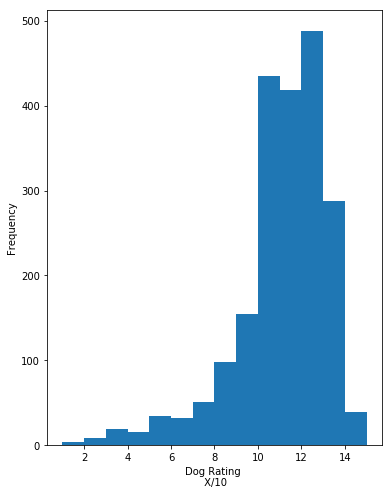

In [204]:
#look at distribution of rankings
plt.xlabel('Dog Rating \n X/10')

df['rating_numerator'].plot(kind='hist',bins=range(1,16),figsize=(6,8));

We have 5 items larger than than 14 in our dataset. These look like outliers - let's take a better look. 

In [94]:
df[df['rating_numerator'] > 13].rating_numerator.unique()

array([  14,   75,   27, 1776,   26,  420], dtype=int64)

In [95]:
#there appear to be clear outliers in the numerators, likely due to some malformed string-harvesting or something else.
# These will be dropped for analysis purposes, for now. 
df[df['rating_numerator'] >14].rating_numerator

526       75
583       27
766     1776
1469      26
1815     420
Name: rating_numerator, dtype: int64

In [96]:
df = df[df['rating_numerator'] <= 14]

In [139]:
#get proportion of dogs who are not good
( df[df['rating_numerator'] < 10]).tweet_id.count() / df.tweet_id.count()

0.19990412272291466

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086 entries, 0 to 2090
Data columns (total 22 columns):
tweet_id              2086 non-null int64
timestamp             2086 non-null datetime64[ns]
source                2086 non-null object
text                  2086 non-null object
expanded_urls         2086 non-null object
rating_numerator      2086 non-null int64
rating_denominator    2086 non-null int64
name                  1384 non-null object
favorite_count        2086 non-null int64
retweet_count         2086 non-null int64
dog_type              2086 non-null category
jpg_url               1963 non-null object
img_num               1963 non-null float64
p1                    1963 non-null object
p1_conf               1963 non-null float64
p1_dog                1963 non-null object
p2                    1963 non-null object
p2_conf               1963 non-null float64
p2_dog                1963 non-null object
p3                    1963 non-null object
p3_conf               196

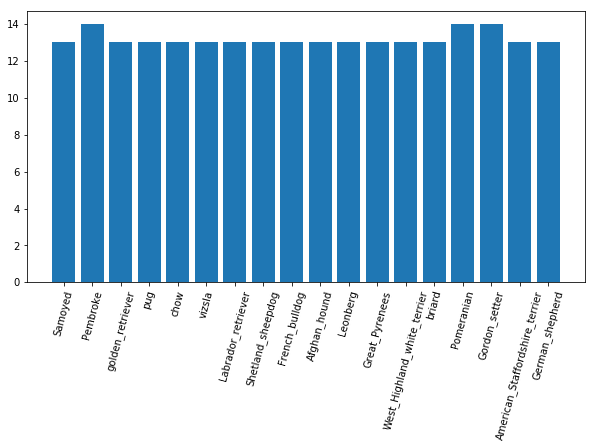

In [202]:
#looking at highest rated dog-types
mask = (df.p1_conf > 0.9) & (df.p1_dog == True) & (df.rating_numerator > 12)
plt.figure(figsize=(10,5))
plt.xticks(rotation=75)
plt.bar(df[mask]['p1'],df[mask]['rating_numerator']);

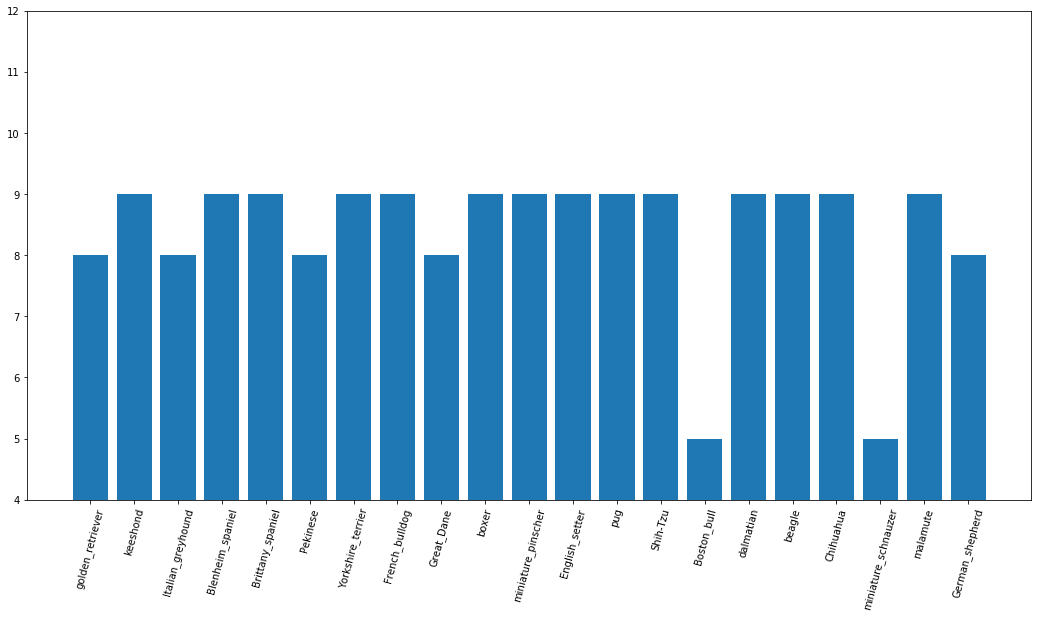

In [124]:
#looking at poorest rated dog-types
mask = (df.p1_conf > 0.9) & (df.p1_dog == True) & (df.rating_numerator < 10)
plt.figure(figsize=(18,9))
plt.xticks(rotation=75)
plt.ylim([4,12])
plt.bar(df[mask]['p1'],df[mask]['rating_numerator']);

In [184]:
#getting counts of dog-types in the dataset
df[df['p1_dog']==True].p1.value_counts().head(10)

golden_retriever      136
Labrador_retriever     94
Pembroke               88
Chihuahua              78
pug                    54
chow                   41
Samoyed                39
Pomeranian             37
toy_poodle             37
malamute               29
Name: p1, dtype: int64

In [188]:
#calculate proportion represented 
(df[df['p1_dog']==True].p1.value_counts() / df[df['p1_dog']==True].p1.value_counts().sum()).head(10)*100

golden_retriever      9.334248
Labrador_retriever    6.451613
Pembroke              6.039808
Chihuahua             5.353466
pug                   3.706246
chow                  2.814001
Samoyed               2.676733
Pomeranian            2.539465
toy_poodle            2.539465
malamute              1.990391
Name: p1, dtype: float64

In [197]:
#getting basic statistics of golden retriever ratings
df[(df['p1_dog'] == True) & (df['p1'] == 'golden_retriever')].rating_numerator.describe()

count    136.000000
mean      11.580882
std        1.325282
min        5.000000
25%       11.000000
50%       12.000000
75%       12.000000
max       14.000000
Name: rating_numerator, dtype: float64

In [198]:
#getting basic statistics of ratings for all dogs
df[df['p1_dog']==True].rating_numerator.describe()

count    1457.000000
mean       10.912148
std         1.692086
min         2.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

In [185]:
df[df['p1_dog']==True].p1.value_counts().sum()

1457

In [156]:
df['p1'].count()

1963